# 뉴스기사 분류모델

## #01. 형태소 분석엔진 설치(colab용)

In [21]:
#!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
#!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

## #02. 패키지

In [22]:
import sys
# sys.path.append("../../")
import helper_colab

import numpy as np
import seaborn as sb
import requests

from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## #03. 데이터셋 준비

### 뉴스기사 데이터셋

In [23]:
origin = read_excel("./news.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62359 entries, 0 to 62358
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  62359 non-null  object
 1   content   62359 non-null  object
dtypes: object(2)
memory usage: 974.5+ KB


In [24]:
origin.head()

,category,content
0,"IT,과학","SKT·SKB·넷플릭스, 망 사용료 소송 취하…분쟁 마침표"
1,"IT,과학",넷플릭스와 SK텔레콤·SK브로드밴드가 2020년 시작한 지난한 법정 다툼을 끝냈다....
2,"IT,과학",앞서 SKB는 넷플릭스 트래픽이 매년 폭증하면서 전송 비용 부담이 막대하지만 넷플릭...
3,"IT,과학",SKT·SKB와 넷플릭스가 화해 모드로 들어가면서 그간 인터넷TV(IPTV) 3사 ...
4,"IT,과학",다만 양측은 망 사용료 지불 등 구체적인 계약 내용에 대해서는 함구했다. 최환석 S...


### 불용어 데이터셋

In [25]:
r = requests.get("https://data.hossam.kr/korean_stopwords.txt")
r.encoding = 'utf-8'
stopwords = r.text.split("\n")
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '...', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '|', '~', '·', '—', '——', '‘', '’', '“', '”', '…', '、', '。', '〈', '〉', '《', '》', '가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공

## #04. 데이터 전처리

### 뉴스기사에서 영어, 특수문자를 제거하고 한글만 남기기

In [26]:
df = origin.copy()

In [27]:
df.columns

Index(['category', 'content'], dtype='object')

In [28]:
# 한글을 제외한 나머지 글자들을 빈 문자열로 대체
df['content'] = df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "", regex=True)

# content 컬럼의 데이터 중에서 빈 문자열만 존재하는 항목은 결측치로 처리
df['content'].replace('', np.nan, inplace=True)

# 전체 데이터셋 크기 확인
print("데이터셋 크기 :", df['content'].shape)

# 결측치 확인
print("결측치 크기 :", df['content'].isna().sum())

데이터셋 크기 : (62359,)
결측치 크기 : 455


### 결측치 제거

In [29]:
df.dropna(inplace=True)
print("결측치 크기 :", df['content'].isna().sum())

결측치 크기 : 0


> 결측치 제거 확인

### 종속변수 라벨링

#### 종속변수 값의 종류

In [30]:
category = list(df['category'].unique())
category

['IT,과학', '경제', '사회', '생활,문화', '세계', '정치']

### 종속변수 값의 종류를 딕셔너리로 변환

In [31]:
cate_dict = {}

for i,v in enumerate(category):
    cate_dict[v] = i    #각 category의 value마다 index를 지정
cate_dict

{'IT,과학': 0, '경제': 1, '사회': 2, '생활,문화': 3, '세계': 4, '정치': 5}

### 종속변수 라벨링

In [32]:
df['category'] = df['category'].map(cate_dict)  #category 값들을 생성한 cate_dict와 mapping
df['category'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

> one-hot-encoing이 필요

### 뉴스기사 형태소 분석

In [52]:
from konlpy.tag import Mecab
if sys.platform == 'win32':
    mecab = Mecab(dicpath="C:/mecab/mecab-ko-dic")
else:
    mecab = Mecab()

# 문장내 형태소 저장할 리스트
word_set = []

# 덧글 내용에 대한 반복 처리
for i,v in enumerate(df['content']):
    # 덧글 하나에 대한 형태소 분석
    morphs = mecab.morphs(v)    #morphs : 형태소 추출
    # print(morphs)
    # if i > 5:
    #     break

    # 형태소 분석 결과에서 불용어를 제외한 단어만 별도의 리스트로 생성
    confirm_words = []
    for j in morphs:
        if j not in stopwords:
            confirm_words.append(j)

    # 불용어를 제외한 형태소 리스트를 통째로 word_set에 저장
    # -> word_set은 2차원 리스트. 1차원은 덧글 단위
    word_set.append(confirm_words)

# 상위 3건만 출력해 확인
print(word_set[:3])

[['넷플릭스', '망', '사용료', '소송', '취하', '분쟁', '마침표'], ['넷플릭스', '텔레콤', '브로드밴드', '가년', '시작', '지난', '법정', '다툼', '끝냈', '다', '오전', '양측', '은', '망', '사용료', '관련', '소송', '취하', '고', '분쟁', '종결', '했', '다', '인공지능', '기술', '활용', '해', '고객', '편익', '강화', '위한', '전략', '파트너', '십', '체결', '며', '협력', '관계', '구축', '기', '했', '다'], ['앞서', '는', '넷플릭스', '트래픽', '매년', '폭', '증하', '면서', '전송', '비용', '부담', '막대', '넷플릭스', '가망', '사용료', '협상', '응하', '는다며', '방송', '통신', '위원회', '재정', '신청', '했', '다', '넷플릭스', '는', '망', '사용료', '지불', '할', '의무', '다며', '서울', '지방', '법원', '채무', '부존', '재확인', '소송', '제기', '했', '다', '심', '법원', '은', '손', '줬', '다', '이후', '넷플릭스', '항소', '고', '반소', '제기', '했', '파트너십', '체결', '싸움', '끝났', '다']]


### 형태소 토큰화

#### 전체 단어에 대한 토큰화

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
print(f'전체 단어수: {len(tokenizer.word_index)}')

전체 단어수: 22569


#### 3회 이상 자주 등장하는 단어의 수 확인

In [37]:
# 사용 빈도가 높다고 판단할 등장 회수
threshold = 3

# 전체 단어의 수
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트할 값
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기 : 22569
등장 빈도가 3번 미만인 희귀 단어의 수: 5653
단어 집합에서 희귀 단어의 비율: 25.047631707209007
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.5051536280196485
단어 집합의 크기 : 16918


#### 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 진행

In [38]:
tokenizer = Tokenizer(vocab_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
print('토큰의 크기 :', len(token_set))

토큰의 크기 : 61904


#### 토큰화 결과의 길이가 0인 항목 찾기

In [39]:
# 토큰화 결과 길이가 0인 항목의 index 찾기
drop_target_index = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_target_index.append(i)

print("길이가 0인 항목의 수: ", len(drop_target_index))

print("길이가 0인 항목의 인덱스 모음: ", drop_target_index)

길이가 0인 항목의 수:  87
길이가 0인 항목의 인덱스 모음:  [9348, 9788, 9790, 9793, 9799, 13155, 13157, 13160, 13166, 16826, 16828, 16831, 16837, 19130, 19132, 19135, 19141, 19296, 24827, 24830, 24835, 24839, 24846, 24851, 24854, 24859, 24860, 24862, 24863, 24865, 24867, 24868, 24870, 24871, 24873, 24874, 24876, 24877, 24879, 24881, 24882, 24884, 24886, 24888, 24889, 24891, 24892, 24894, 24896, 24897, 24899, 24901, 24902, 24904, 24906, 24908, 24910, 24912, 24913, 24915, 24917, 24919, 24921, 24923, 24924, 24926, 24928, 24930, 24932, 24934, 24935, 24937, 24938, 24940, 24941, 24943, 24945, 24947, 24948, 24950, 24952, 54714, 54728, 55453, 55467, 56253, 56267]


#### 토큰화 결과의 길이가 0인 항목 삭제

In [40]:
token_set2 = np.asarray(token_set, dtype="object")

In [41]:
# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set2, drop_target_index, axis=0)

# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(df['category'].values, drop_target_index, axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

독립변수(덧글) 데이터 수:  61817
종속변수(레이블) 데이터 수:  61817


## #05. 탐색적 데이터 분석

### 1. 각 문장별로 몇 개의 단어를 포함하고 있는지 측정

In [44]:
word_counts = []

for s in fill_token_set:
    word_counts.append(len(s))

max_word_count = max(word_counts)
min_word_count = min(word_counts)

print('기사의 최대 단어수 :',max_word_count)
print('기사의 최소 단어수 :',min_word_count)

기사의 최대 단어수 : 225
기사의 최소 단어수 : 1


### 2. 히스토그램으로 단어 분포 수 확인

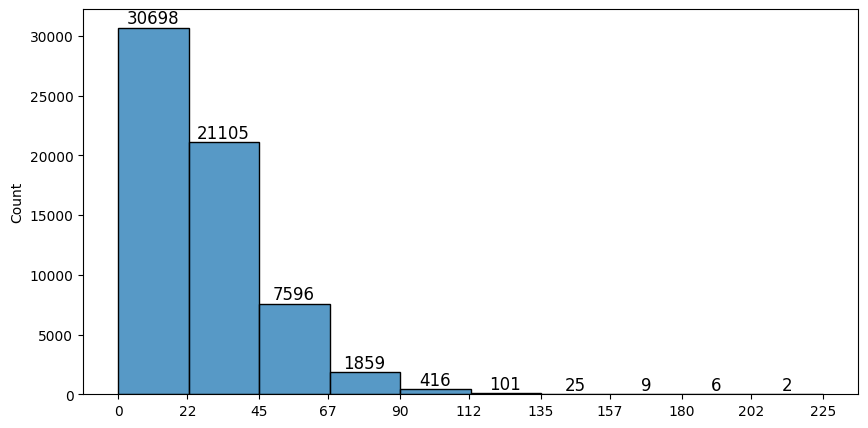

In [45]:
# 히스토그램의 범위 산정
hist_values, hist_bins = np.histogram(word_counts, range=(0, max_word_count), bins=10)
hist_bins = hist_bins.astype(np.int64)

plt.figure(figsize=(10, 5))
sb.histplot(word_counts, bins=10, binrange=(0, max_word_count))
plt.xticks(hist_bins, hist_bins)

for i, v in enumerate(hist_values):
    x = hist_bins[i] + ((hist_bins[i+1] - hist_bins[i]) / 2)
    plt.text(x=x, y=v, s=str(v), fontsize=12, verticalalignment='bottom', horizontalalignment='center')

plt.show()
plt.close()

## #06. 데이터 셋 분할하기

### 랜덤시드 고정

In [46]:
np.random.seed(777)

### 패딩

In [47]:
max_word_count = max(word_counts)
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)
pad_token_set

array([[    0,     0,     0, ...,  1273,   858,  6608],
       [    0,     0,     0, ...,    12,     5,     3],
       [    0,     0,     0, ...,  7170, 11115,     3],
       ...,
       [    0,     0,     0, ...,     8,   427,   156],
       [    0,     0,     0, ...,     0,     0,   449],
       [    0,     0,     0, ...,     0,     0,  1451]])

### 훈련/검증 데이터 분할

In [48]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, label_set, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((43271, 225), (18546, 225), (43271,), (18546,))

### 종속변수(Label)에 대한 one-hot-encoding

In [49]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## #07. 모델 개발

### 모델 정의 (GRU)

>1차는 LSTM, 2차는 GRU로 실행하면 정확성이 높지만 시간이 오래 걸림.

return_sequences 파라미터가 True로 지정되면 모든 학습 시점의 은닉 상태를 출력해 준다. False인 경우는 마지막 시점의 은닉 상태만 출력한다. (기본값=False)

dropout은 지정된 비율만큼 학습을 건너뛰게 하는 파라미터. 이 파라미터를 사용하게 되면 과거 학습정보를 잃어버릴 확률이 높아지고 그에 따라 모델 성능이 나빠질 가능성이 있다.

>dropout은 무작위로 건너뛰는 비율로 학습 속도는 향상되지만 과거 학습 정보를 잃어버릴 확률이 높아져 모델의 성능 저하가 발생할 수 있음.

recurrent_dropout(순환드롭아웃)은 과거 학습정보를 잃어버리는 문제를 해결하기 위해 적용하는 옵션.

- --------------------

> Embedding층은 모델의 첫 번째 층으로만 사용할 수 있으며, 주로 순환 신경망과 연결하여 사용.

- --------------------

 > filter가 클수록, kernel_size가 작을 수록 모델이 성능이 개선됨.
 단, 학습 시간도 오래 걸림.

> activation : 다중분류 = softmax, unit 10, 이진분류 = sigmoid, unit 1/0 - 주로 `relu`

> loss : 다중분류 = categorical_crossentropy, 이진분류 = binary_crossentropy

> Sequential : 모델을 하나 하나 차례로 집어 넣는다

> Dense : 완전 연결 층

> optimizer : 경사하강법 변화 버전(sgd, adam 등등)

> metrics : 평가지표(학습 판단 기준) mse, mae, acc 등

> output_dim : 작아질 수록 정확도 하락, 성능 상승

In [50]:
#모델 개발
model = Sequential()

# input_dim의 크기는 토큰 생성시 지정한 최대 단어수(vocab_size)와 동일하게 설정
# output_dim의 크기는 input_dim보다 작은 값 중에서 설정
model.add(Embedding(input_dim = vocab_size, output_dim = 64))
model.add(GRU(256))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1082752   
                                                                 
 gru (GRU)                   (None, 256)               247296    
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 1331590 (5.08 MB)
Trainable params: 1331590 (5.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 검증 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [51]:
# # 파일이 저장될 경로(폴더) 지정 (한글,공백이 포함되어 있을 경우 에러 발생함)
# if sys.platform == 'win32':
#     checkpoint_path = "D:\\tensorflow_checkpoint\\cp-{epoch:04d}-ckpt"
# else:
#     checkpoint_path = "./cp-{epoch:04d}-ckpt"

# %%time
# result = model.fit(x_train, y_train_one_hot, epochs=500, validation_data=(x_test, y_test_one_hot), callbacks = [
#     EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
#     ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
#     ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
# ])

## #08. 학습결과 평가

자연어 처리는 학습한 데이터 내에서는 정확성이 준수하지만 학습하지 못한 데이터 내에서는 정확성이 떨어짐.

>즉, 자연어 처리는 학습 데이터 양에 따라 성능이 좌우됨.

In [ ]:
# helper_colab.tf_result_plot(result)

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)

# 학습 결과 그래프의 컬럼 명
column_names = result_df.columns

# 학습데이터에 대한 필드이름
train_column_name = [column_names[0], column_names[1]]

# 검증데이터에 대한 필드이름
test_column_name = [column_names[2], column_names[3]]

# 학습 결과 그래프

# # 그래프 객체 생성
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=150)

# # 훈련 및 검증 데이터의 손실률, 절대오차 그래프 그리기
for i, v in enumerate(ax):
    sb.lineplot(x=result_df.index, y=train_column_name[i], data=result_df, color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(x=result_df.index, y=test_column_name[i], data=result_df, color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('ephocs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()

In [ ]:
evaluate1 = model.evaluate(x_train, y_train_one_hot)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test_one_hot)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #09. 학습 결과 적용

### 검증 데이터에 대한 예측 결과 산정

In [ ]:
result = model.predict(x_train, batch_size=10)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [ ]:
arg_result = np.argmax(result, axis=-1)
arg_result

### 학습 결과 확인

결과 데이터 프레임 구성

In [ ]:
kdf = DataFrame({
    'train': y_train,
    'pred' : arg_result
})

kdf['pred'] = kdf['pred'].astype('int')
kdf.head()

### 실제 결과값과 머신러닝에 의한 예측값 비교

In [ ]:
cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sb.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.show()
plt.close()

## #10. 임의의 문장에 대한 분류

In [ ]:
# 임의의 문장
comment = [
        '민주당 총력 투쟁, 한덕수 해임건의안 제출…이재명, 단식 이어간다',
        '중저신용 대출’에 힘썼더니… 인터넷 뱅킹 대출 연체율 사상 최고',
        '영국 노동당 대표 “다음 총선 이기면 브렉시트 협정 개정”',
        '日 어패류 수입량 1년 새 24.8%↓…日 맥주는 323.7% 급증',
        '화웨이 열풍’ 中에서 아이폰15 예약판매 시작 동시 매진',
        '전국 곳곳에 소나기…예년 이맘때보다 더워'
]

# 형태소 분석 엔진
mecab = Mecab()

# 불용어를 제거한 형태소들이 저장될 리스트
word_set = []

# 문장 수 만큼 반복
for c in comment:
    # 형태소 분석
    morphs = mecab.morphs(c)
    # 불용어 제거
    tmp_word = []
    for j in morphs:
        if j not in stopwords:
            tmp_word.append(j)

    word_set.append(tmp_word)

# 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 수행
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)

# 최대 길이에 맞춰서 패딩 처리
pad_token_set = pad_sequences(token_set, maxlen=max_word_count)

# 전처리가 완료된 말뭉치를 학습모델에 적용하여 예측하기
result = model.predict(pad_token_set)

# 결과 분석
arg_result = np.argmax(result, axis=-1)

for i, v in enumerate(arg_result):
    print("%d, %s분야 : %s" % (v, category[v], comment[i]))